# Support set size exploration

In [1]:
import pandas as pd
import duckdb
import os

In [3]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/data/processed/scores/"
support_sizes = [8, 16, 32, 64]

dfs = []

con = duckdb.connect()

for support_size in support_sizes:
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{INPUT_DIR}/*{support_size}.parquet')
    WHERE support_size={support_size}
"""

    df = con.execute(query).df()

    dfs.append(df)

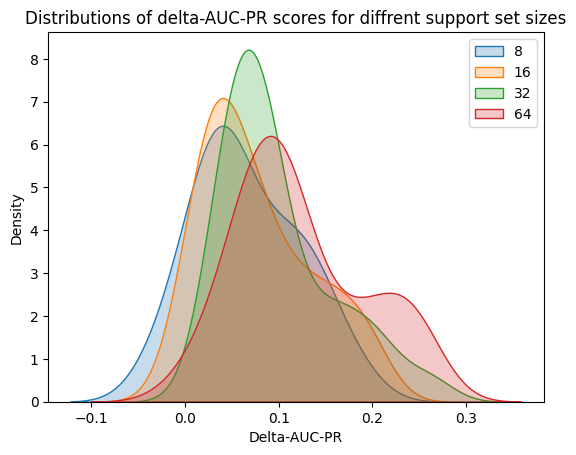

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create overlapping distribution plots
for support_size, df in zip(support_sizes, dfs):
    sns.kdeplot(x=df["delta_auc_pr"], label=support_size, fill=True)

# Provide labels and title
plt.xlabel("Delta-AUC-PR")
plt.ylabel("Density")
plt.title("Distributions of delta-AUC-PR scores for diffrent support set sizes")

# Display the legend
plt.legend()

# Show the plot
plt.show()


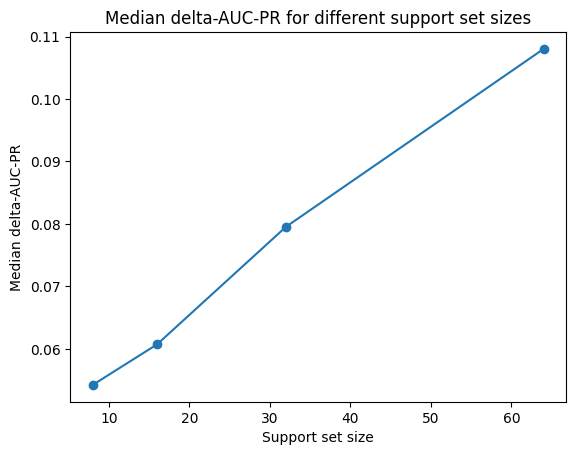

In [31]:
# Get median delta-AUC-PR for each support set size
median_delta_auc_pr = [df["delta_auc_pr"].median() for df in dfs]

# Plot median delta-AUC-PR for each support set size as line plot
plt.plot(support_sizes, median_delta_auc_pr, marker="o")
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes")
plt.show()

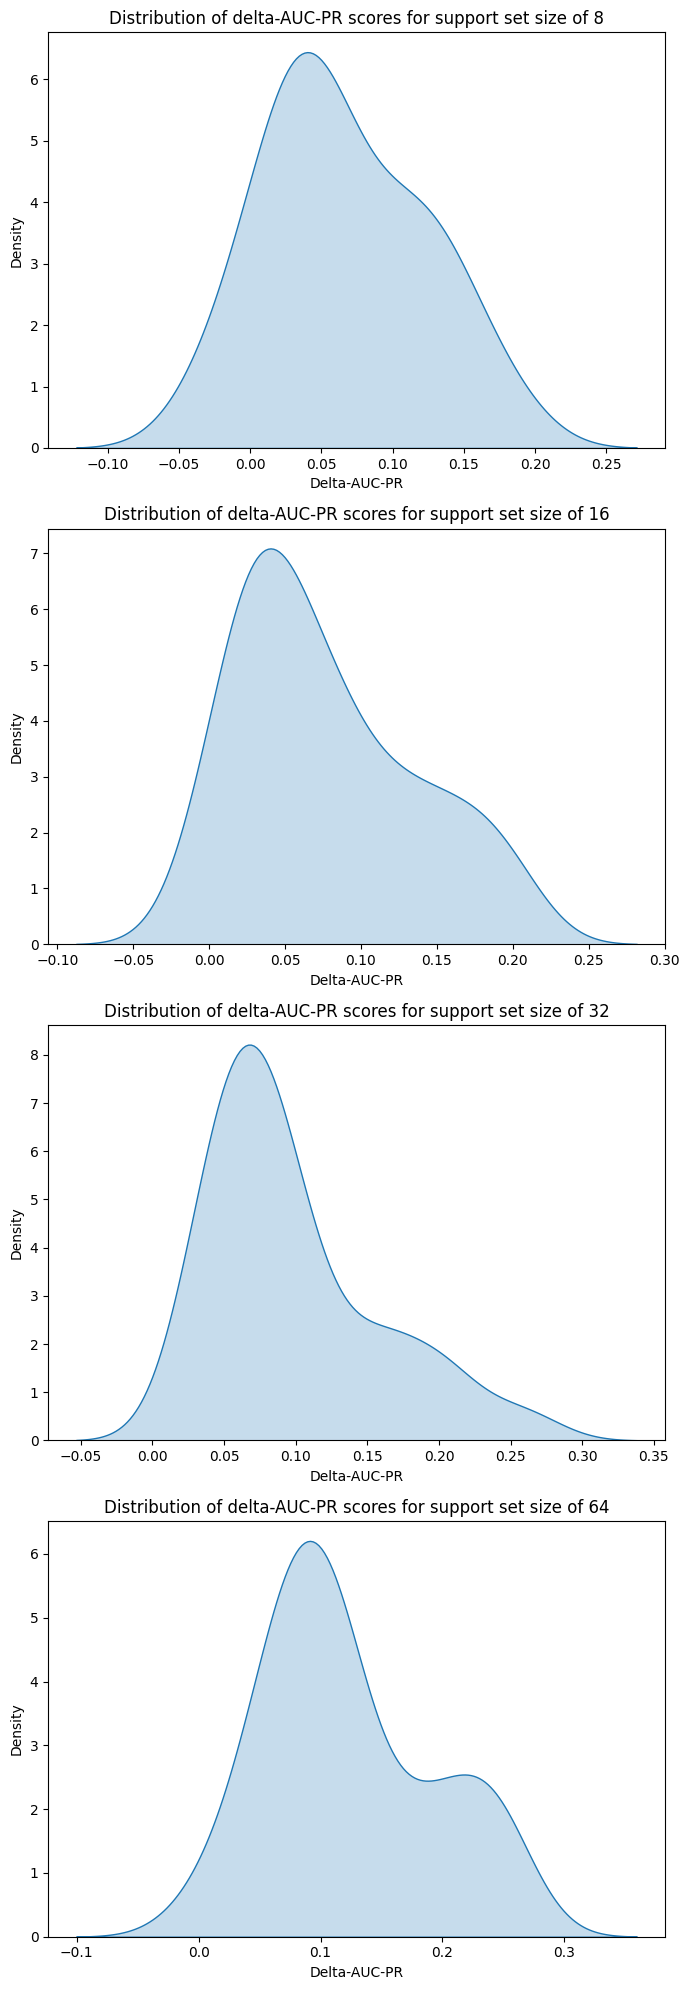

In [32]:
# Determine number of rows for subplots
n = len(dfs)

# Create figure with n subplots
fig, axs = plt.subplots(n, 1, figsize=(7, 5*n))  # Adjust figure size here

# Create subplots
for ax, support_size, df in zip(axs, support_sizes, dfs):
    sns.kdeplot(x=df["delta_auc_pr"], label=support_size, fill=True, ax=ax)
    ax.set_title(f"Distribution of delta-AUC-PR scores for support set size of {support_size}")
    ax.set_xlabel("Delta-AUC-PR")
    ax.set_ylabel("Density")

# Display the plots
plt.tight_layout()  # Ensure that titles and labels don't overlap
plt.show()

These are all identical, which means that support set sizes are not being properly assigned at the stage of assay creation.

## Score by in-vivo vs. in-vitro

I will now split the scores based upon whether they are in the toxvaldb dataset (synonymous with in-vivo) or not. I have not correctly configured how my queries can join tables because the lookup dataframe is not a parquet. I will therefore have to do this approach using filenames.

In [12]:
filenames = os.listdir(INPUT_DIR)

# Initialize empty lists for the two categories of files
toxval_files = []
other_files = []

# Loop over all filenames
for filename in filenames:
    # If 'toxval' is in the filename, add it to the toxval_files list
    if 'toxval' in filename:
        toxval_files.append(filename)
    # Otherwise, add it to the other_files list
    else:
        other_files.append(filename)

dfs = []

con = duckdb.connect()

for support_size in support_sizes:
    query = f"""
    SELECT *
    FROM read_parquet('{INPUT_DIR}/*{support_size}.parquet')
    WHERE support_size={support_size}
"""

    df = con.execute(query).df()

    dfs.append(df)

In [13]:
filenames

['assay_226_cancerrx_logistic_ecfp4_1024_32.parquet',
 'assay_328_prism_logistic_ecfp4_1024_32.parquet',
 'assay_607_cancerrx_logistic_ecfp4_1024_16.parquet',
 'assay_90_prism_logistic_ecfp4_1024_32.parquet',
 'assay_4_cancerrx_logistic_ecfp4_1024_32.parquet',
 'assay_87_prism_logistic_ecfp4_1024_32.parquet',
 'assay_316_cancerrx_logistic_ecfp4_1024_64.parquet',
 'assay_594_cancerrx_logistic_ecfp4_1024_8.parquet',
 'assay_323_cancerrx_logistic_ecfp4_1024_64.parquet',
 'assay_708_cancerrx_logistic_ecfp4_1024_64.parquet',
 'assay_213_cancerrx_logistic_ecfp4_1024_32.parquet',
 'assay_83_cancerrx_logistic_ecfp4_1024_32.parquet',
 'assay_436_prism_logistic_ecfp4_1024_64.parquet',
 'assay_632_cancerrx_logistic_ecfp4_1024_16.parquet',
 'assay_219_cancerrx_logistic_ecfp4_1024_16.parquet',
 'assay_421_prism_logistic_ecfp4_1024_64.parquet',
 'assay_89_cancerrx_logistic_ecfp4_1024_16.parquet',
 'assay_638_cancerrx_logistic_ecfp4_1024_32.parquet',
 'assay_706_cancerrx_logistic_ecfp4_1024_64.parque

In [ ]:
d